<a href="https://colab.research.google.com/github/PureVice/Trabalho-Pratico-2---IBD/blob/main/tp2_ibd_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2-BARRAGENS

> Adicionar aspas





```
# Isto está formatado como código
```

## 0. Importações e Funções Auxiliares


In [ ]:
import csv
import pandas as pd
import sqlite3

import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def fetch(query, conn, formatted=True):
    # execute the query and fetch all rows
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()

    # extract column names from the cursor description
    columns = [desc[0] for desc in cur.description]

    # return a dataframe with column names
    return pd.DataFrame(rs, columns=columns) if formatted else rs

def show_tables(conn):
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]

def shape(table, conn):
    nrows = fetch(f'SELECT COUNT(*) FROM {table}', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]

    return (nrows, ncols)

def desc(table, conn):
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]

    return columns

def info(table, conn):
    # table constraints (domain, null, default, pk)
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)

    # entries per column
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']

    # non-null entries per column
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']

    # unique non-null entries per column
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']

    return df1.merge(df2, left_on='name', right_index=True) \
            .merge(df3, left_on='name', right_index=True) \
            .merge(df4, left_on='name', right_index=True)

def display(urls, cols=5):
    # fetch images
    images = []
    for url in urls:
        response = requests.get(url)
        if response.status_code == 200:
            images.append(Image.open(BytesIO(response.content)))

    # calculate the number of rows
    rows = (len(images) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")  # Hide axes
        else:
            ax.axis("off")  # Hide unused subplots
    plt.tight_layout()
    plt.show()

def hist(data, xlabel='', ylabel='', bins='auto'):
    # convert list of tuples into dataframe
    df = pd.DataFrame(data, columns=['key', 'frequency'])
    # expand the data based on frequencies
    expanded = df.loc[df.index.repeat(df['frequency'])].reset_index(drop=True)

    # plot histogram
    sns.histplot(expanded['key'], bins=bins, kde=False)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

## 1. Inserção dos Dados

In [ ]:
# source dataset: https://www.kaggle.com/datasets/amanbarthwal/imdb-movies-data
source = '/content/drive/MyDrive/TP2_IBD/Barragens.csv'

# connect to SQLite database
conn = sqlite3.connect('barragens.db')
cur = conn.cursor()

# set PRAGMA options for faster ingestion
cur.execute('PRAGMA synchronous = OFF')
cur.execute('PRAGMA journal_mode = MEMORY')

# batch size for processing large datasets
BATCH_SIZE = 1000

# begin transaction for bulk ingestion
cur.execute('BEGIN TRANSACTION')

# read the CSV file and ingest in batches
with open(source, 'r', encoding='latin-1') as f:
    reader = csv.reader(f)
    print(f)
    header = next(reader)  # Read the header row

    # create table with appropriate column names
    columns = [f'"{column}"' for column in header]
    create = f'CREATE TABLE IF NOT EXISTS Source ({", ".join(columns)})'
    cur.execute(create)

    # prepare the INSERT query
    placeholders = ', '.join(['?'] * len(header))
    insert = f'INSERT INTO Source VALUES ({placeholders})'

    # process rows in batches
    batch = []
    for row in reader:
        batch.append(row)
        if len(batch) == BATCH_SIZE:
            # Execute batch insert
            cur.executemany(insert, batch)
            # Reset batch
            batch = []

    # insert any remaining rows
    if batch:
        cur.executemany(insert, batch)

# nullify empty values, so they are recognized as proper nulls
update = f'UPDATE Source SET ' + ','.join([f'{column} = NULLIF({column}, "")' for column in columns])
cur.execute(update)

# commit changes
conn.commit()

# reset PRAGMA options (optional but recommended for safety)
cur.execute('PRAGMA synchronous = FULL')
cur.execute('PRAGMA journal_mode = DELETE')

<_io.TextIOWrapper name='/content/drive/MyDrive/TP2_IBD/Barragens.csv' mode='r' encoding='latin-1'>


## Processamento dos Dados


In [ ]:
import sqlite3

# --- 1. CONEXÃO COM O BANCO DE DADOS ---
# Inicializa as variáveis de conexão como None para um tratamento de erro seguro
conn = None
cur = None

try:
    # Conecta-se ao banco de dados
    conn = sqlite3.connect('barragens.db')
    cur = conn.cursor()

    # Habilita o suporte a chaves estrangeiras para garantir a integridade dos dados
    cur.execute('PRAGMA foreign_keys = ON;')


    # --- 2. CRIAÇÃO E POPULAÇÃO DAS TABELAS ---
    # O script usa "CREATE TABLE IF NOT EXISTS" e "INSERT OR IGNORE"
    # para que possa ser executado múltiplas vezes sem erros.

    # Tabela MUNICÍPIO
    cur.execute('''
        CREATE TABLE IF NOT EXISTS MUNICÍPIO (
            Id INTEGER PRIMARY KEY,
            Nome TEXT NOT NULL,
            UF TEXT NOT NULL,
            UNIQUE(Nome, UF)
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO MUNICÍPIO (Nome, UF)
        SELECT DISTINCT
            "Município",
            "UF"
        FROM Source
        WHERE "Município" IS NOT NULL AND "UF" IS NOT NULL;
    ''')


    # Tabela EMPREENDEDOR
    cur.execute('''
        CREATE TABLE IF NOT EXISTS EMPREENDEDOR (
            Id INTEGER PRIMARY KEY,
            Nome TEXT,
            CPF TEXT UNIQUE NOT NULL
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO EMPREENDEDOR (Nome, CPF)
        SELECT
            MIN("Empreendedor"),
            "CPF_CNPJ"
        FROM Source
        WHERE "CPF_CNPJ" IS NOT NULL
        GROUP BY "CPF_CNPJ";
    ''')


    # Tabela BARRAGEM
    cur.execute('''
        CREATE TABLE IF NOT EXISTS BARRAGEM (
            Id INTEGER PRIMARY KEY,
            Nome TEXT,
            Capacidade_Total REAL,
            Situacao_Operacional TEXT,
            Categoria_Risco_CRI TEXT,
            Pessoas_afetadas INTEGER,
            ImpactoAmbiental TEXT,
            Impacto_Socioeconomico TEXT,
            Nivel_Emergencia TEXT,
            Data_Inicio_Operacao TEXT,
            id_Municipio INTEGER,
            id_Empreendedor INTEGER,
            FOREIGN KEY (id_Municipio) REFERENCES MUNICÍPIO(Id),
            FOREIGN KEY (id_Empreendedor) REFERENCES EMPREENDEDOR(Id)
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO BARRAGEM (
            Id, Nome, Capacidade_Total, Situacao_Operacional, Categoria_Risco_CRI,
            Pessoas_afetadas, ImpactoAmbiental, Impacto_Socioeconomico, Nivel_Emergencia,
            Data_Inicio_Operacao, id_Municipio, id_Empreendedor
        )
        SELECT
            s."ID",
            s."Nome",
            s."Capacidade Total do Reservatório (m³)",
            s."Situação Operacional",
            s."Categoria de Risco - CRI",
            s."Número de pessoas possivelmente afetadas a jusante em caso de rompimento da barragem",
            s."Impacto ambiental",
            s."Impacto sócio-econômico",
            s."Nível de Emergência",
            s."Data de Início de Operação",
            m.Id,
            e.Id
        FROM
            Source s
        LEFT JOIN MUNICÍPIO m ON s."Município" = m.Nome AND s."UF" = m.UF
        LEFT JOIN EMPREENDEDOR e ON s."CPF_CNPJ" = e.CPF;
    ''')


    # Tabela MINERIO
    cur.execute('''
        CREATE TABLE IF NOT EXISTS MINERIO (
            Id INTEGER PRIMARY KEY,
            Nome TEXT UNIQUE NOT NULL
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO MINERIO (Nome)
        SELECT DISTINCT "Minério principal presente no reservatório"
        FROM Source
        WHERE "Minério principal presente no reservatório" IS NOT NULL
          AND "Minério principal presente no reservatório" != '';
    ''')


    # Tabela BARRAGEM_MINERIO
    cur.execute('''
        CREATE TABLE IF NOT EXISTS BARRAGEM_MINERIO (
            id_barragem INTEGER NOT NULL,
            id_minerio INTEGER NOT NULL,
            Teor_Rejeito REAL,
            PRIMARY KEY (id_barragem, id_minerio),
            FOREIGN KEY (id_barragem) REFERENCES BARRAGEM(Id),
            FOREIGN KEY (id_minerio) REFERENCES MINERIO(Id)
        );
    ''')
    cur.execute('''
        INSERT OR IGNORE INTO BARRAGEM_MINERIO (id_barragem, id_minerio, Teor_Rejeito)
        SELECT
            s."ID",
            m.Id,
            s."Teor (%) do minério principal inserido no rejeito"
        FROM
            Source s
        JOIN MINERIO m ON s."Minério principal presente no reservatório" = m.Nome;
    ''')


    # --- 3. FINALIZAÇÃO ---
    conn.commit()
    print("Script executado com sucesso!")
    print("É seguro executar esta célula novamente.")

except Exception as e:
    print(f"Ocorreu um erro: {e}")
    if conn:
        conn.rollback()
finally:
    if cur:
        cur.close()
    if conn:
        conn.close()

Script executado com sucesso!
É seguro executar esta célula novamente.


## 2. Entendendo os Dados


In [ ]:
# show tables
conn = sqlite3.connect('barragens.db')
show_tables(conn)

['Source',
 'MUNICÍPIO',
 'EMPREENDEDOR',
 'BARRAGEM',
 'MINERIO',
 'BARRAGEM_MINERIO']

In [ ]:
# get table shape -- analogous to pandas' shape
for table in show_tables(conn):
  print(table, shape(table, conn))


Source (914, 123)
MUNICÍPIO (186, 3)
EMPREENDEDOR (295, 3)
BARRAGEM (914, 12)
MINERIO (51, 2)
BARRAGEM_MINERIO (564, 3)


In [ ]:
# info table -- analogous to pandas' .info() / .nunique()
info('Source', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ID,,0,None,0,914,914,914
1,1,Nome,,0,None,0,914,914,872
2,2,Empreendedor,,0,None,0,914,914,295
3,3,CPF_CNPJ,,0,None,0,914,914,295
4,4,Nome da mina,,0,None,0,914,340,174
...,...,...,...,...,...,...,...,...,...
118,118,Tipo de Back Up Dam quanto ao material de cons...,,0,None,0,914,914,3
119,119,Tipo de fundação da Back Up Dam,,0,None,0,914,914,3
120,120,Vazão de projeto da Back Up Dam,,0,None,0,914,914,2
121,121,Método construtivo da Back Up Dam,,0,None,0,914,914,2


In [ ]:
# peek into some data

# first rows -- analogous to pandas' head()
#fetch('SELECT * FROM Source ORDER BY "index" ASC LIMIT 2', conn)

# last rows -- analogous to pandas' tail()
#fetch('SELECT * FROM Source ORDER BY "index" DESC LIMIT 2', conn)

# random rows -- analogous to pandas' sample()
fetch('SELECT * FROM Source ORDER BY random() LIMIT 5', conn)

,ID,Nome,Empreendedor,CPF_CNPJ,Nome da mina,UF,Município,Latitude,Longitude,Posicionamento,...,Descarga Máxima do vertedouro da Back Up Dam (m³/seg),Existe documento que ateste a segurança estrutural e a capacidade para contenção de rejeitos da Back Up Dam com ART,Existe manual de operação da Back Up Dam,A Back up Dam passou por auditoria de terceira parte,A Back Up Dam garante a redução da área da mancha de inundação à jusante,Tipo de Back Up Dam quanto ao material de construção,Tipo de fundação da Back Up Dam,Vazão de projeto da Back Up Dam,Método construtivo da Back Up Dam,Tipo de auscultação da Back Up Dam
0,8412,Barragem Lauro Muller,Carbonífera Belluno Ltda.,83163576000105,None,SC,LAURO MÜLLER,-28°24'34.600'',-49°25'39.900'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem
1,8561,SP10,MINERACAO RIO DO NORTE SA,04932216000146,None,PA,ORIXIMINÁ,-01°41'00.600'',-56°27'09.600'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem
2,9295,Dique 1,CARBETO DE SILICIO SIKA BRASIL LTDA,32870697000148,None,MG,ITUTINGA,-21°18'29.660'',-44°39'39.180'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem
3,9693,SR.PEDRINHO,COOPERATIVA DE MINERACAO DOS GARIMPEIROS DE PO...,25252467000150,None,MT,PONTES E LACERDA,-15°08'22.320'',-59°21'30.660'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem
4,9110,Reservatório 01,WHITE SOLDER METALURGIA E MINERACAO LTDA Filia...,04107120000224,None,RO,RIO CRESPO,-09°37'20.200'',-63°03'39.100'',Sul do Equador,...,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem,Não se aplica a esse tipo de barragem


## 4. Consultas


### 3 - Mostra o nome de cada barragem e o nome e UF do município onde ela se encontra



In [ ]:

fetch('''
SELECT
  b.Nome AS Nome_Barragem,
  m.nome AS Nome_Municipio,
  m.UF
FROM
  BARRAGEM AS b
INNER JOIN
  MUNICÍPIO AS m ON b.id_Municipio = m.Id;
''', conn)

,Nome_Barragem,Nome_Municipio,UF
0,CF - Leste,POCONÉ,MT
1,CF - Oeste,POCONÉ,MT
2,Barragem de Clarificação de Água,FERREIRA GOMES,AP
3,Barragem B1A,BRUMADINHO,MG
4,Dique B3,BRUMADINHO,MG
...,...,...,...
909,Sentinela,SERRA DO NAVIO,AP
910,Sedimentacao V,SERRA DO NAVIO,AP
911,Tupa 1,POCONÉ,MT
912,Barragem GMX,NOSSA SENHORA DO LIVRAMENTO,MT


### 4- Mostra o nome da barragem, sua situação operacional e o nome do empreendedor responsável

In [ ]:
fetch('''
SELECT
  b.Nome AS Nome_Barragem,
  b.Situacao_Operacional,
  e.nome AS Nome_Empreendedor
FROM
  BARRAGEM AS b
INNER JOIN
  EMPREENDEDOR AS e ON b.id_Empreendedor = e.Id;''', conn)

,Nome_Barragem,Situacao_Operacional,Nome_Empreendedor
0,CF - Leste,Ativa,ALAIN STEPHANE RIVIERE MINERACAO
1,CF - Oeste,Ativa,ALAIN STEPHANE RIVIERE MINERACAO
2,Barragem de Clarificação de Água,Ativa,Zamapá Mineração S.a.
3,Barragem B1A,Inativa,EMICON MINERACAO E TERRAPLENAGEM LIMITADA
4,Dique B3,Inativa,EMICON MINERACAO E TERRAPLENAGEM LIMITADA
...,...,...,...
909,Sentinela,Inativa,INDUSTRIA E COMERCIO DE MINERIOS S/A - ICOMI
910,Sedimentacao V,Inativa,INDUSTRIA E COMERCIO DE MINERIOS S/A - ICOMI
911,Tupa 1,Inativa,RUBENS GIMENEZ RODRIGUES
912,Barragem GMX,Em Construção,MAX JOEL RUSSI


### 5 - Mostra os nomes das barragens e os tipos de minério que cada uma contém

In [ ]:

fetch('''
SELECT
  bm.id_barragem,
  m.Nome AS Nome_Minerio,
  bm.Teor_Rejeito
FROM
  BARRAGEM_MINERIO AS bm
INNER JOIN
  MINERIO AS m
  ON bm.id_minerio = m.Id;''', conn)

,id_barragem,Nome_Minerio,Teor_Rejeito
0,9148,Aluvião Estanífero,"0,02"
1,9277,Minério de Estanho Secundário,"0,02"
2,9150,Aluvião Estanífero,"0,05"
3,9152,Aluvião Estanífero,"0,05"
4,9692,Aluvião Estanífero,"0,04"
...,...,...,...
559,9158,Minério de Nióbio,"0,50"
560,9156,Minério de Nióbio,"0,50"
561,9027,Minério de Ouro Primário,"0,01"
562,9252,Vermiculita,"15,00"


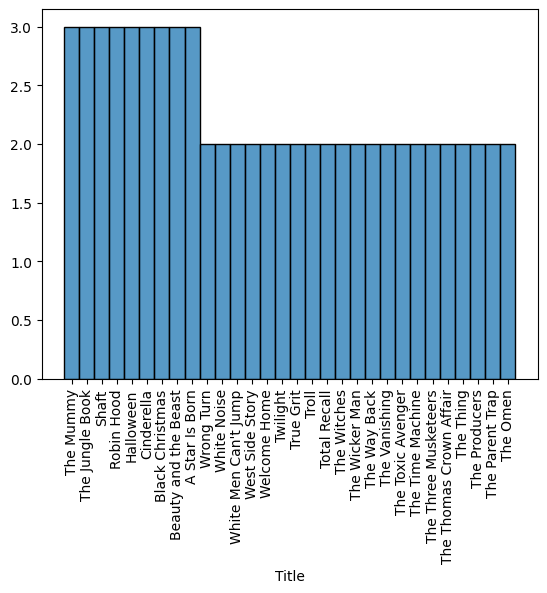

In [ ]:
# get a distribution of movies per title
distro = fetch('SELECT Title, COUNT(*) AS Frequency FROM Source GROUP BY Title HAVING Frequency > 1 ORDER BY Frequency DESC LIMIT 30', conn, False)

# plot histogram
hist(distro, xlabel='Title')

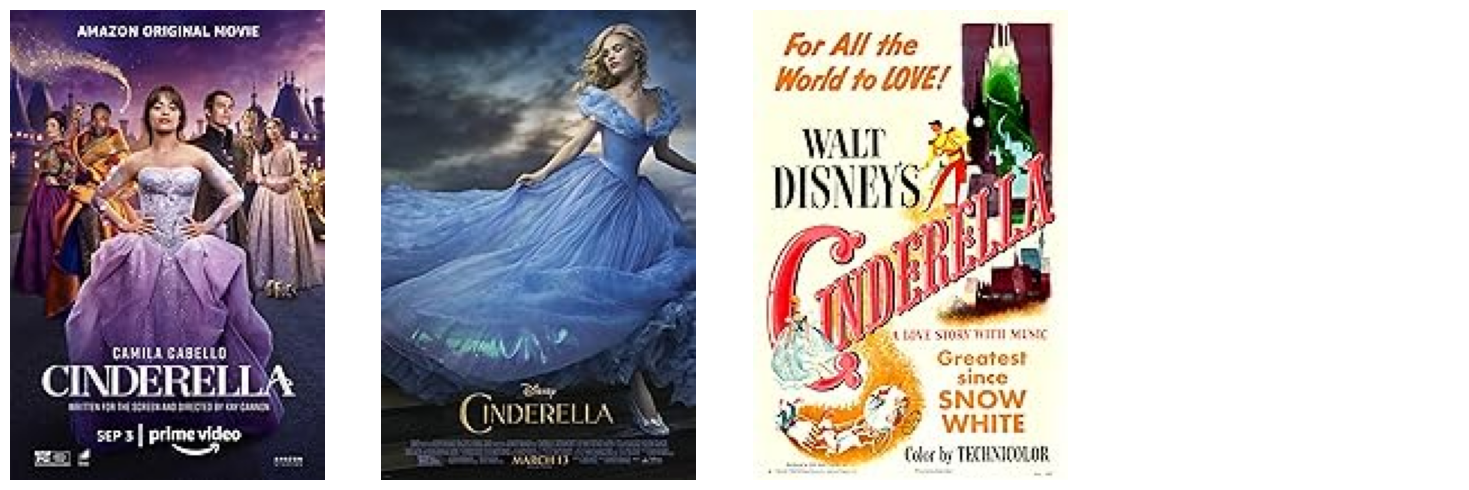

In [ ]:
# titles should be unique in principle;
# check whether duplicates are genuine or just "homonyms"
# (use posters to disambiguate)
urls = [row[0] for row in fetch('''
SELECT Poster FROM Source WHERE Title IN
(SELECT Title FROM Source
 GROUP BY Title HAVING COUNT(*) > 2
 ORDER BY random() LIMIT 1)
 ''', conn, False)]

display(urls, 4)

## 5. Normalization (NÃO EXECUTAR DAQUI PRA BAIXO)

### Key observations

1. Dataset centered around movies -> create a PK
2. No attribute with a defined type -> set appropriate domain constraints
3. Genre and Cast are multivalued -> normalize into separate tables
4. Movie n:1 Director (evidence: common sense) -> normalize into separate tables
5. Movie 1:n Review (evidence: see Review Count) -> normalize into separate tables

### Data migration

#### Prepare source and target schemas

In [ ]:
# prepare source schema
# add MovieID to serve as a unique reference for each row

ddl = [
    'ALTER TABLE Source ADD COLUMN MovieID INTEGER;',
    'UPDATE Source SET MovieID = rowid;'
]

for q in ddl:
    cur.execute(q)

# commit changes
conn.commit()

In [ ]:
# prepare target schema
# define domain, not null, primary key, and foreign key constraints

ddl = [
    '''
    CREATE TABLE IF NOT EXISTS Movie (
        MovieID INTEGER PRIMARY KEY,
        MoviePoster TEXT,
        MovieTitle TEXT NOT NULL,
        MovieYear INTEGER NOT NULL,
        MovieCertificate TEXT,
        MovieDuration INTEGER,
        MovieDescription TEXT,
        MovieRating REAL,
        MovieMetascore INTEGER,
        MovieVotes INTEGER,
        MovieReviews INTEGER,
        DirectorID INTEGER NOT NULL,
        FOREIGN KEY (DirectorID) REFERENCES Director(DirectorID)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Director (
        DirectorID INTEGER PRIMARY KEY,
        DirectorName TEXT NOT NULL
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Actor (
        ActorID INTEGER PRIMARY KEY,
        ActorName TEXT NOT NULL
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Casting (
        MovieID INTEGER NOT NULL,
        ActorID INTEGER NOT NULL,
        PRIMARY KEY (MovieID, ActorID),
        FOREIGN KEY (MovieID) REFERENCES Movie(MovieID),
        FOREIGN KEY (ActorID) REFERENCES Actor(ActorID)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Genre (
        GenreID INTEGER PRIMARY KEY,
        GenreName TEXT NOT NULL
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Classification (
        MovieID INTEGER NOT NULL,
        GenreID INTEGER NOT NULL,
        PRIMARY KEY (MovieID, GenreID),
        FOREIGN KEY (MovieID) REFERENCES Movie(MovieID),
        FOREIGN KEY (GenreID) REFERENCES Genre(GenreID)
    );
    ''',
    '''
    CREATE TABLE IF NOT EXISTS Review (
        ReviewID INTEGER PRIMARY KEY,
        ReviewTitle TEXT NOT NULL,
        ReviewBody TEXT NOT NULL,
        MovieID INTEGER NOT NULL,
        FOREIGN KEY (MovieID) REFERENCES Movie(MovieID)
    );
    '''
]

for q in ddl:
    cur.execute(q)

# commit changes
conn.commit()

In [ ]:
show_tables(conn)

['Source',
 'Movie',
 'Director',
 'Actor',
 'Casting',
 'Genre',
 'Classification',
 'Review']

#### Migrate Director

In [ ]:
# migrate Director

cur.execute('DELETE FROM Director')
cur.execute('''
INSERT INTO Director (DirectorName)
SELECT DISTINCT Director
    FROM Source
    WHERE Director IS NOT NULL
    ORDER BY Director''')

conn.commit()

info('Director', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,DirectorID,INTEGER,0,None,1,3119,3119,3119
1,1,DirectorName,TEXT,1,None,0,3119,3119,3119


#### Migrate Movie

In [ ]:
# migrate Movie

cur.execute('DELETE FROM Movie')
cur.execute('''
INSERT INTO Movie (
    MovieID, MoviePoster, MovieTitle, MovieYear, MovieCertificate, MovieDuration, MovieDescription, MovieRating, MovieMetascore, MovieVotes, MovieReviews, DirectorID
)
SELECT
    MovieID, Poster, Title, Year, Certificate, "Duration (min)", Description, Rating, Metascore, Votes, "Review Count", DirectorID
FROM Source JOIN Director ON Source.Director = Director.DirectorName;''')

conn.commit()

info('Movie', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,MovieID,INTEGER,0,None,1,7190,7190,7190
1,1,MoviePoster,TEXT,0,None,0,7190,7190,7190
2,2,MovieTitle,TEXT,1,None,0,7190,7190,6996
3,3,MovieYear,INTEGER,1,None,0,7190,7190,60
4,4,MovieCertificate,TEXT,0,None,0,7190,7190,30
5,5,MovieDuration,INTEGER,0,None,0,7190,7190,153
6,6,MovieDescription,TEXT,0,None,0,7190,7190,7188
7,7,MovieRating,REAL,0,None,0,7190,7190,75
8,8,MovieMetascore,INTEGER,0,None,0,7190,7190,210
9,9,MovieVotes,INTEGER,0,None,0,7190,7190,7055


#### Migrate Actor and Casting

In [ ]:
# prepare Actor view
view = """
WITH RECURSIVE ActorView AS (
    SELECT
        MovieID,
        TRIM(SUBSTR("Cast", 1, INSTR("Cast" || ',', ',') - 1)) AS ActorName,
        TRIM(SUBSTR("Cast", INSTR("Cast" || ',', ',') + 1)) AS remainder
    FROM
        Source
    WHERE
        "Cast" IS NOT NULL AND "Cast" != ""
    UNION ALL
    SELECT
        MovieID,
        TRIM(SUBSTR(remainder, 1, INSTR(remainder || ',', ',') - 1)) AS ActorName,
        TRIM(SUBSTR(remainder, INSTR(remainder || ',', ',') + 1)) AS remainder
    FROM
        ActorView
    WHERE
        remainder IS NOT NULL AND remainder != ""
)
"""

In [ ]:
# migrate Actor

cur.execute('DELETE FROM Actor')
cur.execute(f'''
INSERT INTO Actor (ActorName)
{view}
SELECT DISTINCT ActorName
    FROM ActorView
    WHERE ActorName IS NOT NULL
    ORDER BY ActorName''')

conn.commit()

info('Actor', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ActorID,INTEGER,0,None,1,11525,11525,11525
1,1,ActorName,TEXT,1,None,0,11525,11525,11525


In [ ]:
# migrate Casting

cur.execute('DELETE FROM Casting')
cur.execute(f'''
INSERT INTO Casting (MovieID, ActorID)
{view}
SELECT DISTINCT MovieID, ActorID
    FROM Actor JOIN ActorView
        ON Actor.ActorName = ActorView.ActorName
''')

conn.commit()

info('Casting', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,MovieID,INTEGER,1,None,1,29444,29444,7190
1,1,ActorID,INTEGER,1,None,2,29444,29444,11525


In [ ]:
# sanity check: who are the actors of MovieID 3654?
fetch('''
SELECT MovieID, ActorID, ActorName
FROM Casting NATURAL JOIN Actor
WHERE MovieID = 3654
''', conn)

,MovieID,ActorID,ActorName
0,3654,79,Adam Wingard
1,3654,1618,Calvin Lee Reeder
2,3654,1788,Chad Villella
3,3654,2567,David Bruckner
4,3654,3857,Glenn McQuaid
5,3654,4027,Hannah Fierman
6,3654,5203,Joe Swanberg
7,3654,5728,Justin Martinez
8,3654,6354,Lane Hughes
9,3654,8870,Radio Silence


In [ ]:
# sanity check: who are the actors of MovieID 3654?
pd.set_option('display.max_colwidth', None)
fetch('SELECT "Cast" FROM Source WHERE MovieID = 3654', conn)

,Cast
0,"David Bruckner, Tyler Gillett, Justin Martinez, Glenn McQuaid, Radio Silence, Joe Swanberg, Chad Villella, Ti West, Adam Wingard, Calvin Lee Reeder, Lane Hughes, Adam Wingard, Hannah Fierman"


#### Migrate Genre and Classification

In [ ]:
# prepare Genre view
view = """
WITH RECURSIVE GenreView AS (
    SELECT
        MovieID,
        TRIM(SUBSTR("Genre", 1, INSTR("Genre" || ',', ',') - 1)) AS GenreName,
        TRIM(SUBSTR("Genre", INSTR("Genre" || ',', ',') + 1)) AS remainder
    FROM
        Source
    WHERE
        "Genre" IS NOT NULL AND "Genre" != ""
    UNION ALL
    SELECT
        MovieID,
        TRIM(SUBSTR(remainder, 1, INSTR(remainder || ',', ',') - 1)) AS GenreName,
        TRIM(SUBSTR(remainder, INSTR(remainder || ',', ',') + 1)) AS remainder
    FROM
        GenreView
    WHERE
        remainder IS NOT NULL AND remainder != ""
)
"""

In [ ]:
# migrate Genre

cur.execute('DELETE FROM Genre')
cur.execute(f'''
INSERT INTO Genre (GenreName)
{view}
SELECT DISTINCT GenreName
    FROM GenreView
    WHERE GenreName IS NOT NULL
    ORDER BY GenreName''')

conn.commit()

info('Genre', conn)


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,GenreID,INTEGER,0,None,1,22,22,22
1,1,GenreName,TEXT,1,None,0,22,22,22


In [ ]:
# migrate Classification

cur.execute('DELETE FROM Classification')
cur.execute(f'''
INSERT INTO Classification (MovieID, GenreID)
{view}
SELECT DISTINCT MovieID, GenreID
    FROM Genre JOIN GenreView
        ON Genre.GenreName = GenreView.GenreName
''')

conn.commit()

info('Classification', conn)


,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,MovieID,INTEGER,1,None,1,18713,18713,7190
1,1,GenreID,INTEGER,1,None,2,18713,18713,22


In [ ]:
# sanity check: what are the genres of MovieID 3654?
fetch('''
SELECT MovieID, GenreID, GenreName
FROM Classification NATURAL JOIN Genre
WHERE MovieID = 3654
''', conn)

,MovieID,GenreID,GenreName
0,3654,13,Horror
1,3654,16,Mystery
2,3654,20,Thriller


In [ ]:
# sanity check: who are the actors of MovieID 3654?
pd.set_option('display.max_colwidth', None)
fetch('SELECT Genre FROM Source WHERE MovieID = 3654', conn)

,Genre
0,"Horror, Mystery, Thriller"


#### Migrate Review

In [ ]:
# migrate Review

cur.execute('DELETE FROM Review')
cur.execute(f'''
INSERT INTO Review (ReviewTitle, ReviewBody, MovieID)
SELECT "Review Title", Review, MovieID
FROM Source
''')

conn.commit()

info('Review', conn)

,cid,name,type,notnull,dflt_value,pk,count,notnull count,unique count
0,0,ReviewID,INTEGER,0,None,1,7190,7190,7190
1,1,ReviewTitle,TEXT,1,None,0,7190,7190,7022
2,2,ReviewBody,TEXT,1,None,0,7190,7190,7190
3,3,MovieID,INTEGER,1,None,0,7190,7190,7190


#### Clean up

In [ ]:
# drop source table
cur.execute('DROP TABLE Source;')
conn.commit()

show_tables(conn)

['Movie', 'Director', 'Actor', 'Casting', 'Genre', 'Classification', 'Review']

In [ ]:
# close cursor and connection
cur.close()
conn.close()